In [1]:
import numpy as np

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from itertools import product

import cv2

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


x_train, _, y_train, _ = train_test_split(x_train,y_train, train_size=0.5, stratify=y_train)
x_test, _, y_test, _ = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test)

In [3]:
input_dim = (32,32,3)
input_img = Input(shape=input_dim)

cl1_template = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same',
             input_shape=input_dim, activation='relu')
cl1 = cl1_template(input_img)
pl1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(cl1)

cl2 = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same',
             activation='relu')(pl1)
pl2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(cl2)

cl3 = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same',
             activation='relu')(pl2)
pl3 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(cl3)

cl4 = Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same',
             activation='relu')(pl3)
pl4 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(cl4)

cl5 = Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same',
             activation='relu')(pl4)
pl5 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(cl5)

flat = Flatten()(pl5)

fc6 = Dense(units=4096, activation='relu')(flat)
fc7 = Dense(units=4096, activation='relu')(fc6)

output = Dense(units=10, activation='softmax')(fc7)

In [4]:
classifier = Model(input_img, output)

opt = RMSprop(learning_rate=0.001)
classifier.compile(optimizer=opt, loss ='binary_crossentropy',
                   metrics = ['accuracy'])
print(classifier.summary())
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_delta=1e-4,
                              mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35,
                         restore_best_weights=True, verbose=1)

hist = classifier.fit(x_train, y_train, batch_size=100,
                      epochs=10, callbacks=[stop_alg, reduce_lr],
                      shuffle=True, validation_data=(x_test, y_test))
classifier.save_weights("cnn.hdf5")

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)        

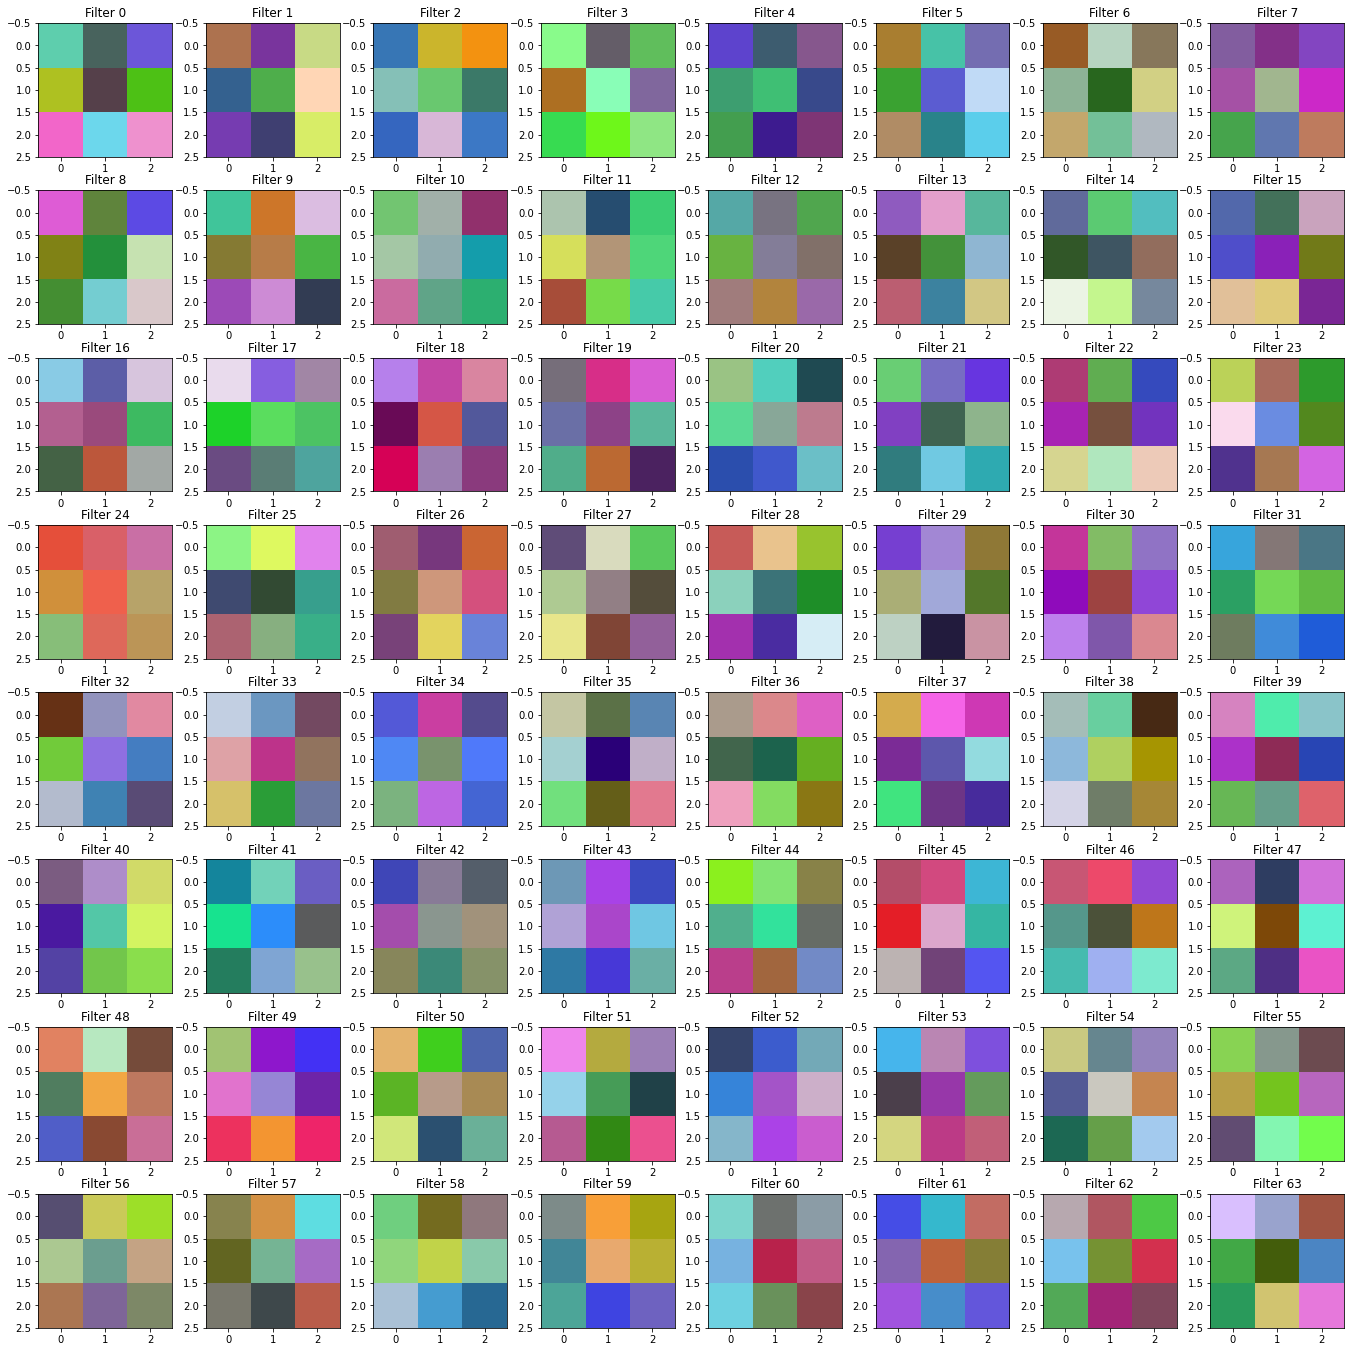

In [5]:
def plotFilter(filter):
    wshape = filter.shape
    scaler = MinMaxScaler()
    scaler.fit(filter.reshape(-1,1))
    filter = scaler.transform(filter.reshape(-1,1))
    filter = filter.reshape(wshape)

    fig, axs = plt.subplots(8,8, figsize=(24,24))
    fig.subplots_adjust(hspace = .25, wspace=.001)
    axs = axs.ravel()
    for i in range(filter.shape[-1]):
        h = np.reshape(filter[:,:,:,i], (3,3,3))
        axs[i].imshow(h)
        axs[i].set_title('Filter ' + str(i))

_cnnl1 = classifier.layers[1].name
W = classifier.get_layer(name=_cnnl1).get_weights()[0]
plotFilter(W)